# Clean and extract information from surveys done by kictchen supervisors

### Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

### Code

In [2]:
## Read the data 
df_supervisor = pd.read_excel('../../1. Data available/ISHTM_Hadhreen/New_Hadhreen kitchen Supervisors Survey Results 11_01_2025.xlsx')

##remove the two first lines and set the third as the column names 
df_supervisor = df_supervisor.iloc[2:]
df_supervisor = df_supervisor.rename(columns=df_supervisor.iloc[0])
df_supervisor = df_supervisor.iloc[1:]

## Remove na values 
df_supervisor = df_supervisor[df_supervisor['Locality'].notna()]

##Select the column we are interested in 
df_supervisor = df_supervisor[['Kitchen Name', 'Locality', 
                              'Are the nearest markets functional?', 
                               'What alternative sources of food are available to families in your service area',
                              'What are the current price levels for staple foods in your area?',
                              'Is home farming an available food source for families in your service area?', 
                              'If yes,Percentage of Household Food from Farming',
                              'Do all residents of the area depend on the central kitchen or the hospice only, or are there other sources for meals?'
                              ]]
df_supervisor.columns = ['kitchen_name', 
                        'locality', 
                        'functional_market',
                         'alternative_sources_family',
                        'price_level',
                        'house_farming_availability',
                        'percentage_house_farming',
                        'dependancy_kitchen']

## Clean column one by one 
## Clean Locality to match kitchen id ones
df_supervisor.loc[df_supervisor["locality"] == "East Nile", "locality"] = 'Sharg An Neel'
df_supervisor.loc[df_supervisor["locality"] == " Omdurman", "locality"] = 'Um Durman'
df_supervisor.loc[df_supervisor["locality"] == "Jebel Awliya", "locality"] = 'Jebel Awlia'

## Clean food supply
possibilities = ['other Hadhreen Kitchen', 'Other central kitchens', 'Other central kitchens, Food aid from UN/NGOs']
df_supervisor['other_sources_family'] = ['Yes' if item in possibilities else 'No' for item in df_supervisor['alternative_sources_family']]

## Percentage of house farming
df_supervisor.loc[df_supervisor["percentage_house_farming"] == " more than 50%", "percentage_house_farming"] = '> 50%'
df_supervisor.loc[df_supervisor["percentage_house_farming"] == "less than 25%", "percentage_house_farming"] = '< 25%'
df_supervisor.loc[df_supervisor["percentage_house_farming"] == "between 25% - 50%", "percentage_house_farming"] = 'between 25-50%'

## Dependancy kitchen
df_supervisor.loc[df_supervisor["dependancy_kitchen"] == "Yes, full reliance", "dependancy_kitchen"] = 'Full reliance'
df_supervisor.loc[df_supervisor["dependancy_kitchen"] == "No, Partial reliance", "dependancy_kitchen"] = 'Partial reliance'

## Save data 
df_supervisor.to_excel('../output/supervisor_kitchen_information.xlsx', index = False)

### Visualization

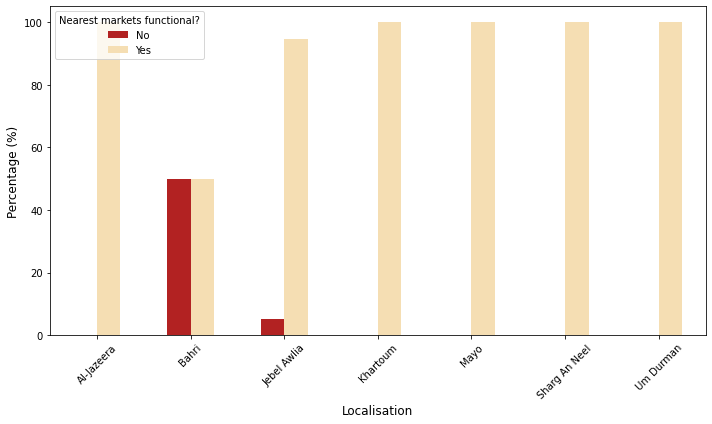

In [3]:
## calculate number of functional market
frequency = df_supervisor.groupby(['locality', 'functional_market']).size().reset_index(name='Counts')

# Sort the DataFrame by translated_location alphabetically
frequency = frequency.sort_values(by='locality')

# Pivot the DataFrame to get counts per location and frequency of coming
pivot_df = frequency.pivot(index='locality', columns='functional_market', values='Counts')

# Calculate percentages for each location
pivot_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Define custom colors for each frequency
colors = ['firebrick', 'wheat']  # Custom colors for each category

# Plot the data
pivot_percentage.plot(kind='bar', stacked=False, figsize=(10, 6), color=colors)

# Add labels and title
plt.xlabel('Localisation', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Nearest markets functional?')

plt.savefig('../visualization/supervisor_market_functional.png', dpi=300)

# Show the plot
plt.show()

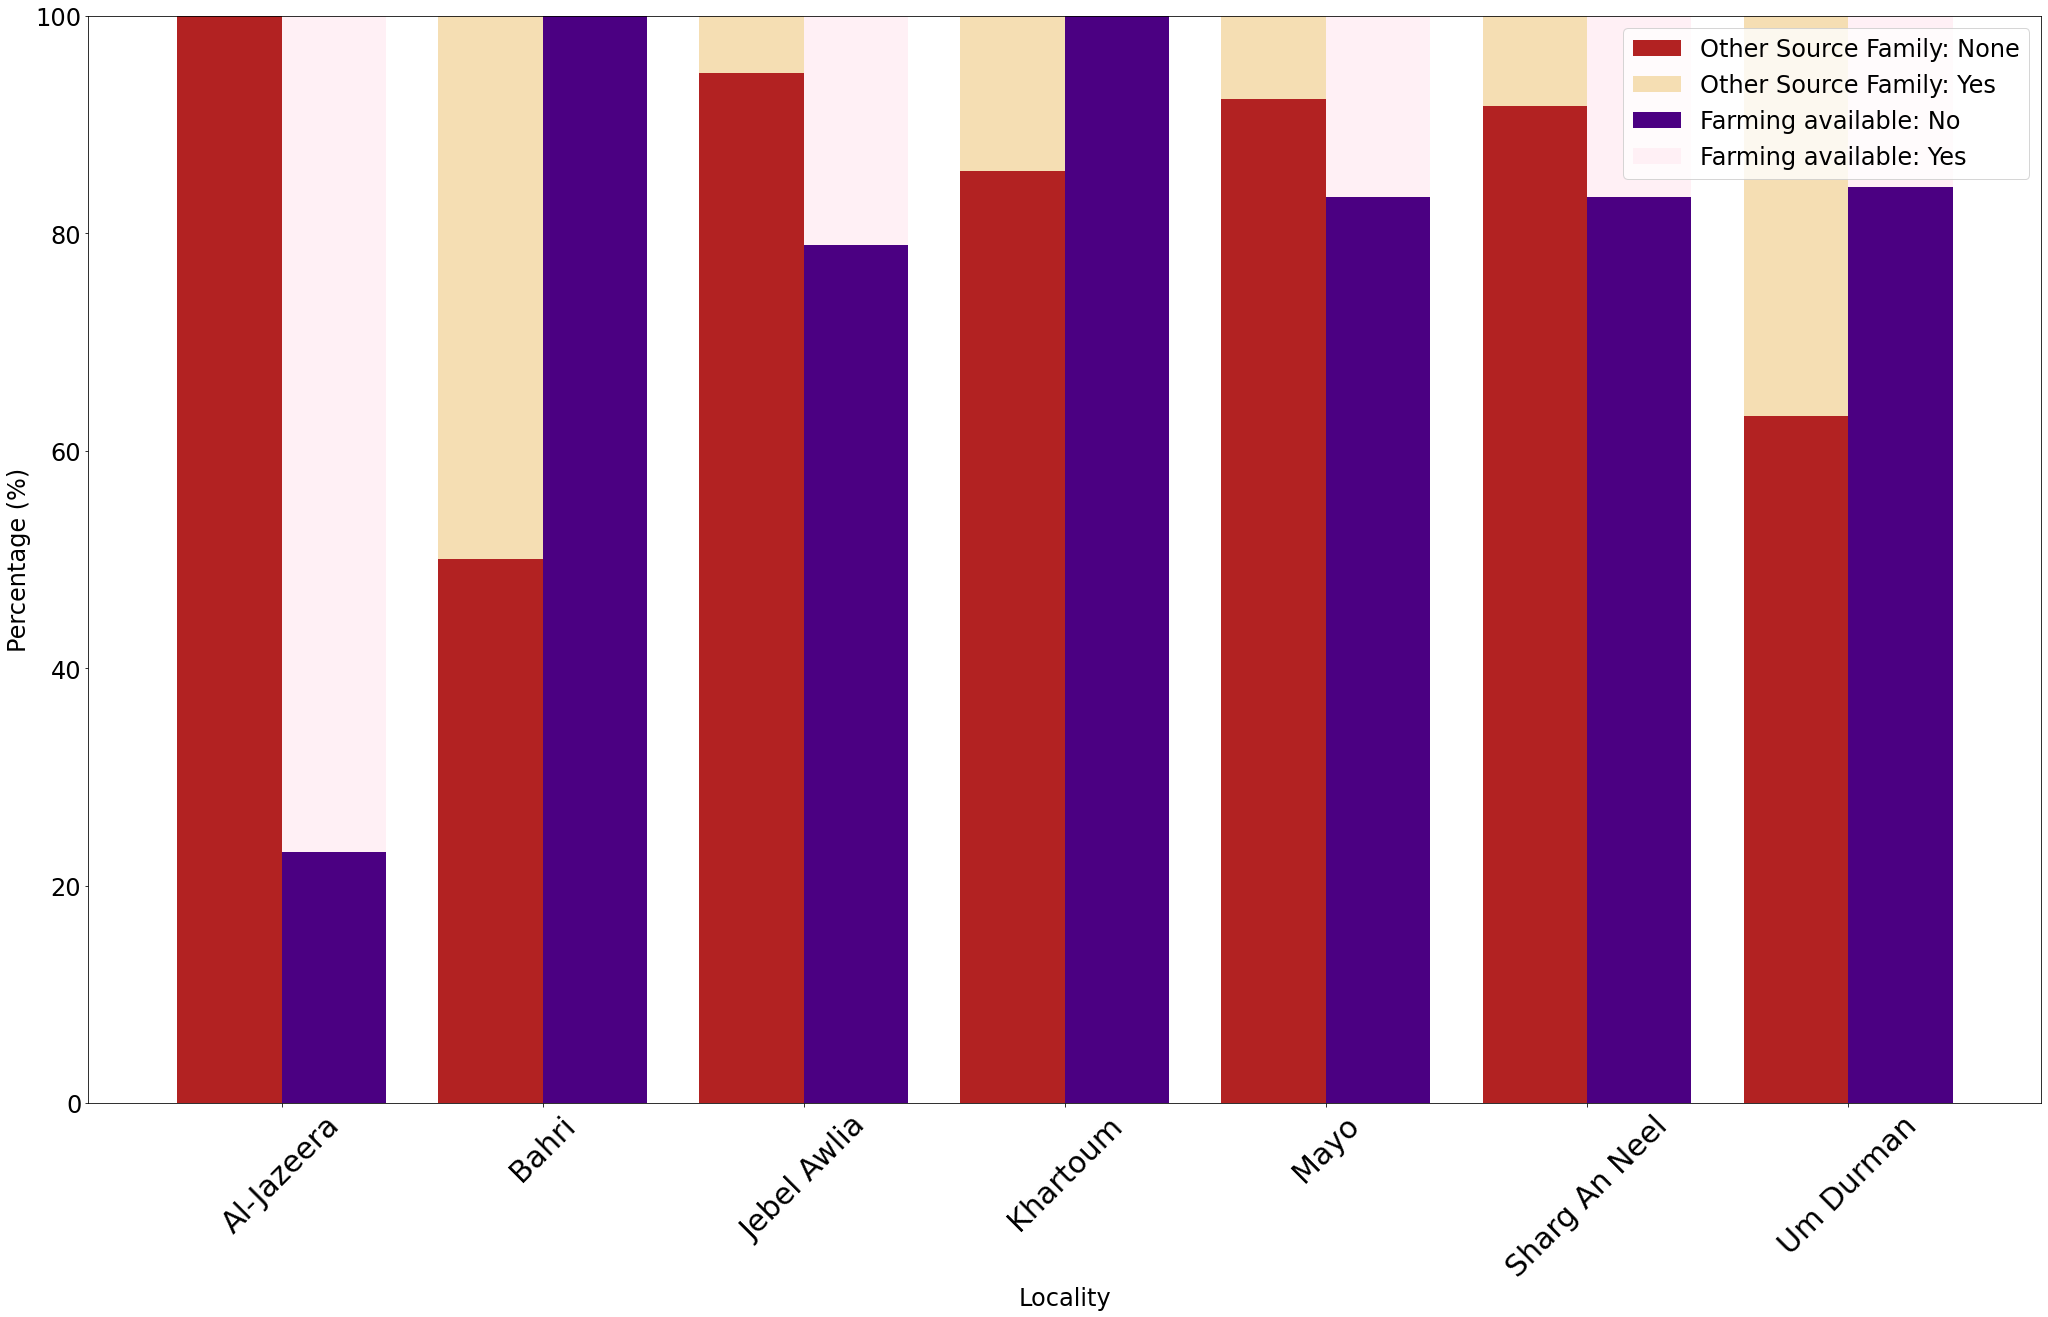

In [4]:
# Step 1: Calculate percentages
summary = df_supervisor.groupby('locality').apply(lambda x: pd.Series({
    'other_source_yes': (x['other_sources_family'].value_counts(normalize=True).get('Yes', 0) * 100),
    'other_source_no': (x['other_sources_family'].value_counts(normalize=True).get('No', 0) * 100),
    'house_farming_yes': (x['house_farming_availability'].value_counts(normalize=True).get('Yes', 0) * 100),
    'house_farming_no': (x['house_farming_availability'].value_counts(normalize=True).get('No', 0) * 100)
})).reset_index()

# Step 2: Plot stacked bars
bar_width = 0.4  # Width of each bar
x = range(len(summary['locality']))  # X positions for each locality
# Set figure size
plt.figure(figsize=(35,  20))

# Plot for "Other Source Family"
plt.bar(x, summary['other_source_no'], label='Other Source Family: None', color='firebrick', width=bar_width)
plt.bar(x, summary['other_source_yes'], bottom=summary['other_source_no'], label='Other Source Family: Yes', color='wheat', width=bar_width)

# Plot for "House Farming Family" (shifted to the right)
plt.bar([i + bar_width for i in x], summary['house_farming_no'], label='Farming available: No', color='indigo', width=bar_width)
plt.bar([i + bar_width for i in x], summary['house_farming_yes'], bottom=summary['house_farming_no'], label='Farming available: Yes', color='lavenderblush', width=bar_width)

# Formatting the plot
plt.xticks([i + bar_width / 2 for i in x], summary['locality'] , rotation=45, fontsize=30)  # Center x-ticks
plt.xlabel('Locality', fontsize=24)
plt.yticks(fontsize = 24)
plt.ylabel('Percentage (%)', fontsize=24)
plt.legend(fontsize = 24)
plt.ylim(0, 100)
#plt.tight_layout()
plt.savefig('../visualization/supervisor_other_family_sources.png', dpi=500)
plt.show()

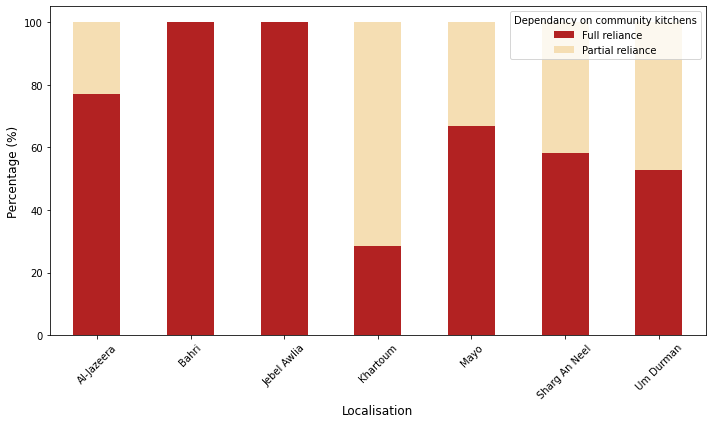

In [5]:
## calculate frequency
dependancy = df_supervisor.groupby(['locality', 'dependancy_kitchen']).size().reset_index(name='Counts')

# Sort the DataFrame by translated_location alphabetically
dependancy = dependancy.sort_values(by='locality')

# Pivot the DataFrame to get counts per location and frequency of coming
pivot_df = dependancy.pivot(index='locality', columns='dependancy_kitchen', values='Counts')

# Calculate percentages for each location
pivot_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Define custom colors for each frequency
colors = ['firebrick', 'wheat']  # Custom colors for each category

# Plot the data
pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Add labels and title
plt.xlabel('Localisation', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
#plt.title('Counts by Location and kitchen_dependancy', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
# Order the legend based on a custom list (e.g., alphabetically by frequency)
ordered_legend_labels = ['Full reliance', 'Partial reliance']
# Change legend title and order
plt.legend(title='Dependancy on community kitchens', labels=ordered_legend_labels)

plt.savefig('../visualization/supervisors_dependancy_kitchens.png', dpi=300)

# Show the plot
plt.show()

In [6]:
## Plot the number of supervisor who answered compared to the number of kitchens per area
# We need to read the kictchen_ids_cluster file to calculate the number of kitchens per location
kitchen_ids_cluster = pd.read_excel('../output/kitchen_ids_cluster.xlsx')
## Calculate number of kitchen
nbs = []
nbs.append(len(kitchen_ids_cluster.loc[kitchen_ids_cluster['kitchen_locality'] == 'Jebel Awlia']))
nbs.append(len(kitchen_ids_cluster.loc[kitchen_ids_cluster['kitchen_locality'] == 'Um Durman']))
nbs.append(len(kitchen_ids_cluster.loc[kitchen_ids_cluster['kitchen_locality'] == 'Khartoum']))
nbs.append(len(kitchen_ids_cluster.loc[kitchen_ids_cluster['kitchen_state'] == 'Sinnar']))
nbs.append(len(kitchen_ids_cluster.loc[kitchen_ids_cluster['kitchen_locality'] == 'Sharg An Neel']))
nbs.append(len(kitchen_ids_cluster.loc[kitchen_ids_cluster['kitchen_state'] == 'Gazeera']))

nbs = pd.DataFrame(nbs)
nbs['location'] = ['Jebel Awlia', 'Um Durman', 'Khartoum', 'Sinnar', 'Sharg An Neel', 'Gazeera']
nbs.columns = ['nbs_kitchen', 'location']

## calculate number of kitchen per location
counts_kitchen = df_supervisor.groupby(['kitchen_name', 'locality']).size().reset_index(name='Counts')['locality'].value_counts()
counts_kitchen = counts_kitchen.reset_index()
counts_kitchen.columns = ['location', 'nbs_kitchen_answered']

## Merge both
results = pd.merge(nbs, counts_kitchen, on='location', how='left')
print(results)

   nbs_kitchen       location  nbs_kitchen_answered
0           54    Jebel Awlia                  19.0
1            4      Um Durman                  19.0
2           60       Khartoum                   7.0
3            1         Sinnar                   NaN
4           19  Sharg An Neel                  12.0
5           14        Gazeera                   NaN


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


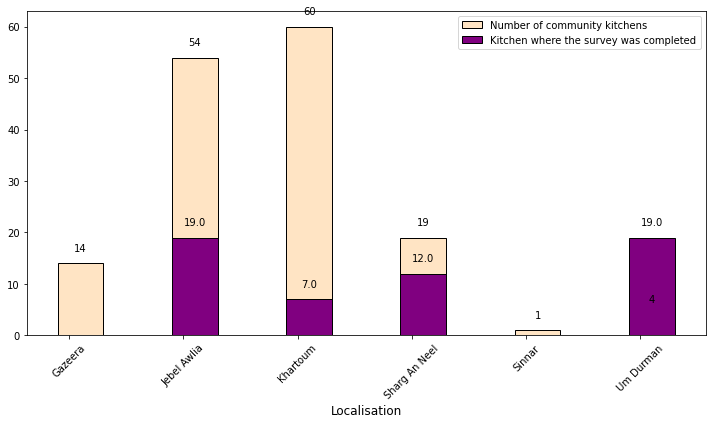

In [7]:
# Sort the DataFrame by translated_location alphabetically
results = results.sort_values(by='location')

# Set figure size
plt.figure(figsize=(10, 6))

# Bar width
bar_width = 0.4

# Bar positions
x = range(len(results))  # Positions for locations
x_answ = [pos + bar_width /4 for pos in x]
x_kitchen = [pos + bar_width /4 for pos in x]

# Plot bars for nbs_kitchen
plt.bar(x_kitchen, results['nbs_kitchen'], width=bar_width, label='Number of community kitchens', color='bisque', edgecolor='black')

# Plot bars for nbs_kitchen
plt.bar(x_answ, results['nbs_kitchen_answered'], width=bar_width, label='Kitchen where the survey was completed', color='purple', edgecolor='black')

# Add numbers on top of bars for nbs_kitchen
for i, value in enumerate(results['nbs_kitchen']):
    plt.text(x_kitchen[i], value + 2, str(value), ha='center', va='bottom', fontsize=10, color='black')

# Add numbers on top of bars for nbs_kitchen
for i, value in enumerate(results['nbs_kitchen_answered']):
    plt.text(x_answ[i], value + 2, str(value), ha='center', va='bottom', fontsize=10, color='black')

# Add labels, title, and legend
plt.xlabel('Localisation', fontsize=12)
#plt.ylabel('Counts', fontsize=12)
#plt.title('Number of beneficiaries and kitchen by location', fontsize=14)
plt.xticks(x, results['location'], rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig('../visualization/supervisors_answered_kitchens.png', dpi=300)

# Show the plot
plt.show()